In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.dates as md

import matplotlib.dates as mdates

In [2]:
tmy_stations = pd.read_csv('input-data/tmy3/tmy3_stations.csv')

In [3]:
len(tmy_stations)

1020

In [4]:
states_gdf = gpd.read_file('input-data/geo/US_states/cb_2017_us_state_500k.shp')
states_gdf = states_gdf.rename(columns={'GEOID': 'state_fips',
                                        'NAME': 'state_name'})

In [5]:
tmy_stations_gdf = gpd.GeoDataFrame(tmy_stations, 
                                    geometry=gpd.points_from_xy(tmy_stations.longitude, tmy_stations.latitude))
tmy_stations_gdf.crs = "EPSG:4326"
tmy_stations_gdf = tmy_stations_gdf.to_crs(states_gdf.crs)


In [6]:
tmy_stations_gdf = tmy_stations_gdf.sjoin(states_gdf[['state_fips', 'state_name', 'geometry']], how='left')
tmy_stations_gdf.drop(columns=['index_right'], inplace=True)

In [7]:
### Pick the day with the highest temperature and lowest temperature to estimate hour-based HVAC and BTMS power

temperature_list = [-10,-5,0,5,10,15,20,25,30,35,40]
HVAC_power_list = [25,17,10,6,4,1,1,2,4,7,11]
BTMS_power_list = [4.9,3.6,2.1,0.8,0.2,0.1,0.1,1.4,1.5,2.1,5.6]

total_temp_energy_list = [HVAC_power_list[i] + BTMS_power_list[i] for i in range(len(HVAC_power_list))]

## Add two extreme values to make sure we cover all temperature values

min_temp = -100
max_temp = 100
min_temp_power = (-10 - min_temp) * (total_temp_energy_list[0] - total_temp_energy_list[1]) / 5 + total_temp_energy_list[0]
max_temp_power = (max_temp - 40) * (total_temp_energy_list[-1] - total_temp_energy_list[-2]) /5 + total_temp_energy_list[-1]

In [8]:
### Extend temp and energy list

temperature_list = [-100] + temperature_list + [100]
total_temp_energy_list = [min_temp_power] + total_temp_energy_list + [max_temp_power]

### Define a dataframe to store the information
df_temp_energy = pd.DataFrame({'Temp_C':temperature_list,'Power':total_temp_energy_list})

In [9]:
df_temp_energy

,Temp_C,Power
0,-100,197.3
1,-10,29.9
2,-5,20.6
3,0,12.1
4,5,6.8
5,10,4.2
6,15,1.1
7,20,1.1
8,25,3.4
9,30,5.5


In [10]:
## Fill every integer Temp_C
df_tmp_fill = pd.DataFrame({'Temp_C':[i for i in range(-100,101)]})

In [11]:
df_temp_energy = df_tmp_fill.merge(df_temp_energy,on='Temp_C',how= 'left')

In [12]:
## Linear interpolate
df_temp_energy['Power'] = df_temp_energy['Power'].interpolate(method='linear')

df_temp_energy['Temp_C'] = df_temp_energy['Temp_C'].astype(float)

In [13]:
df_temp_energy.head()

,Temp_C,Power
0,-100.0,197.30
1,-99.0,195.44
2,-98.0,193.58
3,-97.0,191.72
4,-96.0,189.86


In [14]:
### Now get all the stations within a state
state_name = "Utah"

state_tmy_stations_gdf = tmy_stations_gdf[tmy_stations_gdf.state_name==state_name].reset_index(drop=True)

In [15]:
state_tmy_stations_gdf

,usaf,site_name,latitude,longitude,geometry,state_fips,state_name
0,725755,OGDEN HILL AFB,41.117,-111.967,POINT (-111.96700 41.11700),49,Utah
1,724756,BRYCE CNYN FAA AP,37.700,-112.150,POINT (-112.15000 37.70000),49,Utah
2,725705,VERNAL,40.433,-109.517,POINT (-109.51700 40.43300),49,Utah
3,725720,SALT LAKE CITY INT'L ARPT [ISIS],40.770,-111.970,POINT (-111.97000 40.77000),49,Utah
4,724723,BLANDING,37.617,-109.483,POINT (-109.48300 37.61700),49,Utah
5,724755,CEDAR CITY MUNICIPAL AP,37.700,-113.100,POINT (-113.10000 37.70000),49,Utah
6,724735,HANKSVILLE,38.367,-110.717,POINT (-110.71700 38.36700),49,Utah
7,725810,WENDOVER USAF AUXILIARY FIELD,40.717,-114.033,POINT (-114.03300 40.71700),49,Utah
8,724776,MOAB/CANYONLANDS [UO],38.580,-109.540,POINT (-109.54000 38.58000),49,Utah
9,724754,SAINT GEORGE (AWOS),37.083,-113.600,POINT (-113.60000 37.08300),49,Utah


In [16]:
### We might further find the stations within the transit system's service area

# select city for analysis
#city = 'Niagara_Region_Transit'
city = 'saltlake'

# load shape data where we can get the min and max of lat/lon
df_shape = pd.read_csv(f'./../GTFS_Data/{city}/shapes.txt', sep=',', header=0)

In [17]:
### Get the max and min of lat/lon
min_lat = df_shape.shape_pt_lat.min()
max_lat = df_shape.shape_pt_lat.max()

min_lon = df_shape.shape_pt_lon.min()
max_lon = df_shape.shape_pt_lon.max()

In [18]:
print(min_lat,max_lat,min_lon,max_lon)

39.97557 41.52831 -112.30457 -111.5435


In [19]:
### Now we try to extract all stations within the bounding box
from geopy.distance import great_circle


state_tmy_stations_gdf = tmy_stations_gdf[(tmy_stations_gdf.latitude <= max_lat) &
                                           (tmy_stations_gdf.latitude >= min_lat) & 
                                            (tmy_stations_gdf.longitude <= max_lon) &
                                            (tmy_stations_gdf.longitude >= min_lon) ].reset_index(drop=True)
### If no weather stations within the bounding box, we find the station nearest to the center of the bounding box
if state_tmy_stations_gdf.shape[0] == 0:
    ## Calculate the center point
    lat_center = (min_lat + max_lat)/2
    lon_center = (min_lon + max_lon)/2
    ## calculate the great_circle distance to each station
    tmy_stations_gdf['GCD_dist'] = tmy_stations_gdf.apply(lambda x: great_circle((lat_center,lon_center), (x['latitude'], x['longitude'])).mi)

    state_tmy_stations_gdf = tmy_stations_gdf[tmy_stations_gdf['GCD_dist'] == tmy_stations_gdf['GCD_dist'].min()]   

In [20]:
state_tmy_stations_gdf

,usaf,site_name,latitude,longitude,geometry,state_fips,state_name
0,725755,OGDEN HILL AFB,41.117,-111.967,POINT (-111.96700 41.11700),49,Utah
1,725720,SALT LAKE CITY INT'L ARPT [ISIS],40.770,-111.970,POINT (-111.97000 40.77000),49,Utah
2,725724,PROVO MUNI (AWOS),40.217,-111.717,POINT (-111.71700 40.21700),49,Utah
3,725750,OGDEN HINKLEY AIRPORT,41.200,-112.017,POINT (-112.01700 41.20000),49,Utah


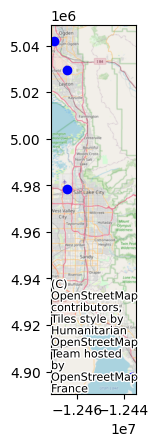

In [21]:
## Visualization

import matplotlib.pyplot as plt
import contextily as cx

fig, ax = plt.subplots(1, 1)

state_tmy_stations_gdf.crs = 4326
state_tmy_stations_gdf = state_tmy_stations_gdf.to_crs(epsg=3857)

state_tmy_stations_gdf.plot(ax = ax, legend=True,figsize=[8,4],color = 'blue')
cx.add_basemap(ax)#, zoom=15,source=cx.providers.CartoDB.Voyager)#, source=cx.providers.Stamen.TonerLite)#source=cx.providers.CartoDB.Voyager)# source=cx.providers.Stamen.TonerLite) 
#fig.savefig('{}_TMY3_Stations.png'.format(state_name),dpi = 300)


In [22]:
# Get the hourly TMY3 data (per station)
tmy3_data = pd.read_csv('input-data/tmy3/tmy3_hourly_data.csv', parse_dates=['ts'])
tmy3_data['date'] = tmy3_data.ts.dt.date
tmy3_data = tmy3_data.sort_values(by='drybulb_c', ascending=True)

In [23]:
print(tmy3_data.date.min(),tmy3_data.date.max())

2001-01-01 2002-01-02


In [24]:
### Count the number of data points for each day

tmy3_data_count = tmy3_data.groupby(['date']).usaf.count()
tmy3_data_count = tmy3_data_count.reset_index()

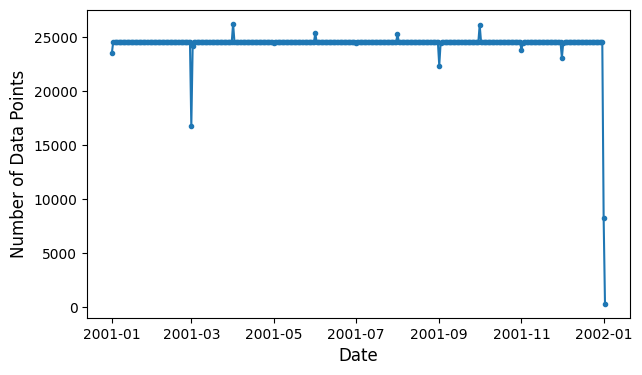

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(7,4))

plt.plot(tmy3_data_count['date'], tmy3_data_count['usaf'],marker = '.')

#plt.title('Instances of Grade and kWhs', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Data Points', fontsize=12)
#formatter = FuncFormatter(to_percent)
#plt.gca().yaxis.set_major_formatter(formatter)
fig.savefig('TMY3.png',dpi=300,bbox_inches = "tight")

In [26]:
### Based on the above observation, we decide to drop the last two days
print(tmy3_data.shape[0])
tmy3_data = tmy3_data[~tmy3_data['date'].isin([datetime.date(2002, 1, 1),datetime.date(2002, 1, 2)])]
print(tmy3_data.shape[0])

8935200
8926692


In [27]:
## Extract data for the region of interest and look at the distribution/variation of the temperature

tmy3_data_region = tmy3_data[tmy3_data.usaf.isin(state_tmy_stations_gdf['usaf'].unique())]

In [28]:
len(tmy3_data_region.date.unique())

365

In [29]:
### Get the hour of the day
tmy3_data_region['hod'] = tmy3_data_region['ts'].dt.hour

In [30]:
### Merge the temparature-based power values
tmy3_data_region = pd.merge_asof(tmy3_data_region, df_temp_energy,
                                            left_on='drybulb_c',
                                            right_on='Temp_C',
                                            direction='forward')

In [31]:
tmy3_data_region

,usaf,ts,drybulb_c,date,hod,Temp_C,Power
0,725755,2001-12-19 06:00:00,-15.0,2001-12-19,6,-15.0,39.20
1,725755,2001-12-19 08:00:00,-15.0,2001-12-19,8,-15.0,39.20
2,725724,2001-12-11 07:00:00,-14.4,2001-12-11,7,-14.0,37.34
3,725750,2001-02-09 04:00:00,-14.0,2001-02-09,4,-14.0,37.34
4,725750,2001-02-09 06:00:00,-14.0,2001-02-09,6,-14.0,37.34
...,...,...,...,...,...,...,...
34983,725724,2001-07-16 17:00:00,38.0,2001-07-16,17,38.0,13.60
34984,725724,2001-07-19 15:00:00,38.0,2001-07-19,15,38.0,13.60
34985,725724,2001-07-13 17:00:00,38.0,2001-07-13,17,38.0,13.60
34986,725720,2001-07-05 16:00:00,38.3,2001-07-05,16,39.0,15.10


In [32]:
### Check the daily average for each station and each day

tmy3_data_region_group = tmy3_data_region.groupby(['usaf','date']).agg({'drybulb_c':['mean','max','min']})
tmy3_data_region_group.columns = ['c_mean','c_max','c_min']
tmy3_data_region_group = tmy3_data_region_group.reset_index()

In [33]:
tmy3_data_region_group

,usaf,date,c_mean,c_max,c_min
0,725720,2001-01-01,0.852174,7.8,-3.9
1,725720,2001-01-02,-1.012500,5.6,-8.3
2,725720,2001-01-03,-8.345833,-2.8,-13.3
3,725720,2001-01-04,-5.366667,-2.2,-11.7
4,725720,2001-01-05,-2.512500,1.7,-6.7
...,...,...,...,...,...
1455,725755,2001-12-27,3.750000,6.0,2.0
1456,725755,2001-12-28,3.570833,5.0,1.0
1457,725755,2001-12-29,4.212500,7.0,3.0
1458,725755,2001-12-30,6.375000,9.0,4.0


In [34]:
#### Get the coldest and hottest date for each station
#### And extract the corresponding power consumption data
list_df_hot = []
list_df_cold = []
for usaf_tmp in tmy3_data_region_group.usaf.unique():
    df_station_tmp = tmy3_data_region_group[tmy3_data_region_group.usaf == usaf_tmp]
    cold_day = df_station_tmp[df_station_tmp.c_mean == df_station_tmp.c_mean.min()]['date'].iloc[0]
    hot_day = df_station_tmp[df_station_tmp.c_mean == df_station_tmp.c_mean.max()]['date'].iloc[0]

    df_cold = tmy3_data_region[(tmy3_data_region.usaf == usaf_tmp)&(tmy3_data_region.date == cold_day)]
    df_hot = tmy3_data_region[(tmy3_data_region.usaf == usaf_tmp)&(tmy3_data_region.date == hot_day)]
    ### Take the hourly average within each day to deal with situations where mutiple values are recorded for one hour
    df_cold_hourly = df_cold.groupby('hod').agg({"usaf":'first','ts':'first',"drybulb_c":"mean","date":'first',"Temp_C":'mean',"Power":"mean",})
    df_hot_hourly = df_hot.groupby('hod').agg({"usaf":'first','ts':'first',"drybulb_c":"mean","date":'first',"Temp_C":'mean',"Power":"mean",})
    df_cold_hourly = df_cold_hourly.reset_index()
    df_hot_hourly = df_hot_hourly.reset_index()
    
    list_df_hot.append(df_hot_hourly)
    list_df_cold.append(df_cold_hourly)

df_hot_all = pd.concat(list_df_hot)
df_cold_all = pd.concat(list_df_cold)

In [35]:
13*24

312

In [36]:
## Check whether we have 312 rows
print(df_hot_all.shape)
print(df_cold_all.shape)

(96, 7)
(96, 7)


In [37]:
### Next lets get the hourly average values for all stations

df_cold_hourly = df_cold_all.groupby(['hod']).agg({"Power":"mean"})
df_hot_hourly = df_hot_all.groupby(['hod']).agg({"Power":"mean"})


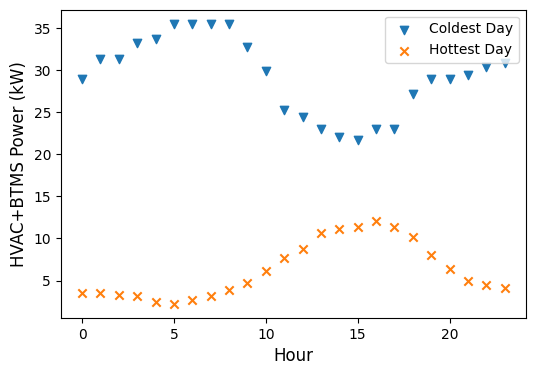

In [38]:
### Visualize cold and hot HVAC energy consumption powers

%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
import numpy as np

fig, ax = plt.subplots(figsize=(6,4))


ax.scatter(range(24), df_cold_hourly[('Power')].to_list(), marker = 'v',
             label="Power during Coldest Day")
ax.scatter(range(24), df_hot_hourly[('Power')].to_list(), marker = 'x',
             label="Power during Hottest Day")
#for marker in ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']:
   
plt.legend(["Coldest Day","Hottest Day"])


plt.xlabel('Hour', fontsize=12)
plt.ylabel('HVAC+BTMS Power (kW)', fontsize=12)

fig.savefig('HVAC_Power_Hot_Cold_{}_GTFS_Based.png'.format(state_name),dpi=300,bbox_inches = "tight")

In [44]:
##### Check and visualize the station-wise variations

In [40]:
### Get the min and max for daily values

tmy3_daily_maxmin = tmy3_data_region_group.groupby('usaf').agg({"c_mean":['max','min'],
                                                               "c_max":['max','min'],
                                                               "c_min":['max','min']})

tmy3_daily_maxmin = tmy3_daily_maxmin.reset_index()

In [41]:
tmy3_daily_maxmin

usaf     c_mean            c_max      c_min      
                 max        min   max  min   max   min
0  725720  29.933333  -8.345833  38.3 -2.8  25.0 -13.3
1  725724  29.041667 -10.612500  39.0 -8.5  21.6 -14.4
2  725750  29.666667  -9.583333  37.0 -6.0  22.0 -14.0
3  725755  29.654167 -10.750000  38.0 -6.0  24.0 -15.0

In [42]:
tmy3_daily_maxmin.columns

MultiIndex([(  'usaf',    ''),
            ('c_mean', 'max'),
            ('c_mean', 'min'),
            ( 'c_max', 'max'),
            ( 'c_max', 'min'),
            ( 'c_min', 'max'),
            ( 'c_min', 'min')],
           )

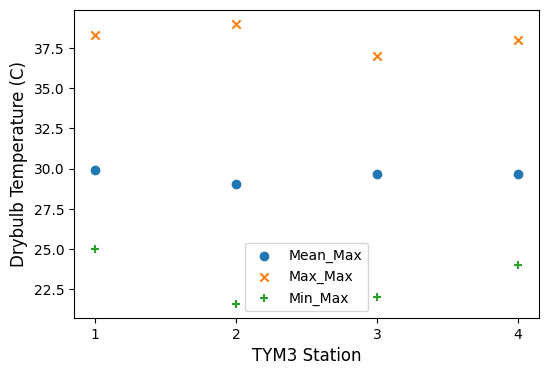

In [43]:
### Visualize station temperature variations

%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
import numpy as np

fig, ax = plt.subplots(figsize=(6,4))

tmy3_daily_maxmin[(  'usaf',    '')] = range(1,tmy3_daily_maxmin.shape[0]+1)
tmy3_daily_maxmin[(  'usaf',    '')] = tmy3_daily_maxmin[(  'usaf',    '')].astype(str)
ax.scatter(tmy3_daily_maxmin[(  'usaf',    '')].to_list(), tmy3_daily_maxmin[('c_mean', 'max')].to_list(), marker = 'o',
             label="Mean_Max")
ax.scatter(tmy3_daily_maxmin[(  'usaf',    '')].to_list(), tmy3_daily_maxmin[( 'c_max', 'max')].to_list(), marker = 'x',
             label="Max_Max")
ax.scatter(tmy3_daily_maxmin[(  'usaf',    '')].to_list(), tmy3_daily_maxmin[( 'c_min', 'max')].to_list(), marker = '+',
             label="Min_Max")
#for marker in ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']:
   
plt.legend(["Mean_Max","Max_Max","Min_Max"])


plt.xlabel('TYM3 Station', fontsize=12)
plt.ylabel('Drybulb Temperature (C)', fontsize=12)

fig.savefig('{}_Max_Check_GTFS_Based.png'.format(state_name),dpi=300,bbox_inches = "tight")

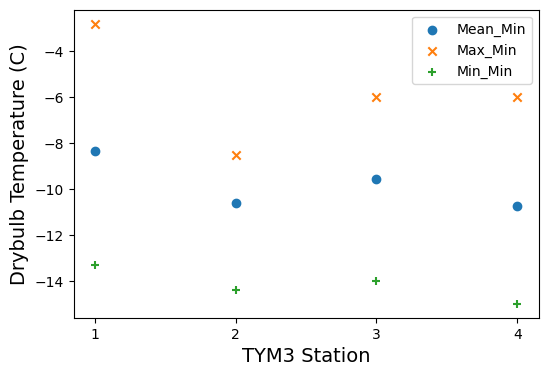

In [45]:
### Visualize station temperature variations

%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
import numpy as np

fig, ax = plt.subplots(figsize=(6,4))

tmy3_daily_maxmin[(  'usaf',    '')] = range(1,tmy3_daily_maxmin.shape[0]+1)
tmy3_daily_maxmin[(  'usaf',    '')] = tmy3_daily_maxmin[(  'usaf',    '')].astype(str)
ax.scatter(tmy3_daily_maxmin[(  'usaf',    '')].to_list(), tmy3_daily_maxmin[('c_mean', 'min')].to_list(), marker = 'o',
             label="Mean_Min")
ax.scatter(tmy3_daily_maxmin[(  'usaf',    '')].to_list(), tmy3_daily_maxmin[( 'c_max', 'min')].to_list(), marker = 'x',
             label="Max_Min")
ax.scatter(tmy3_daily_maxmin[(  'usaf',    '')].to_list(), tmy3_daily_maxmin[( 'c_min', 'min')].to_list(), marker = '+',
             label="Min_Min")
#for marker in ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']:
   
plt.legend(["Mean_Min","Max_Min","Min_Min"])


plt.xlabel('TYM3 Station', fontsize=14)
plt.ylabel('Drybulb Temperature (C)', fontsize=14)

fig.savefig('{}_Min_Check_GTFS_Based.png'.format(state_name),dpi=300,bbox_inches = "tight")